In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_2')

In [3]:
sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size

In [4]:
kmeans_list = [pd.read_csv(path) for path in evals_dir.glob('*_km*.csv')]
df_kmeans = pd.concat(kmeans_list, ignore_index=True)

In [5]:
datasets_dict = {
    'chains_eq_2_300': 'Chain length = 2, 300d',
    'chains_eq_3_300': 'Chain length = 3, 300d',
    'chains_ge_4_lt_10_50': 'Chain 10 > length >= 4, 50d',
    'chains_eq_3_50': 'Chain length = 3, 50d',
    'chains_ge_10_300': 'Chain length >= 10, 50d',
    'chains_ge_4_lt_10_300': 'Chain 10 > length >= 4, 300d',
    'chains_eq_2_50': 'Chain length = 2, 50d',
    'chains_ge_10_50': 'Chain length >= 10, 50d'}

In [6]:
score_colors = [colors.TABLEAU_COLORS['tab:blue'],colors.TABLEAU_COLORS['tab:orange'],colors.TABLEAU_COLORS['tab:green']]

In [41]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_kmeans['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy, - Better']
ncols = len(scores)
nrows = len(datasets)

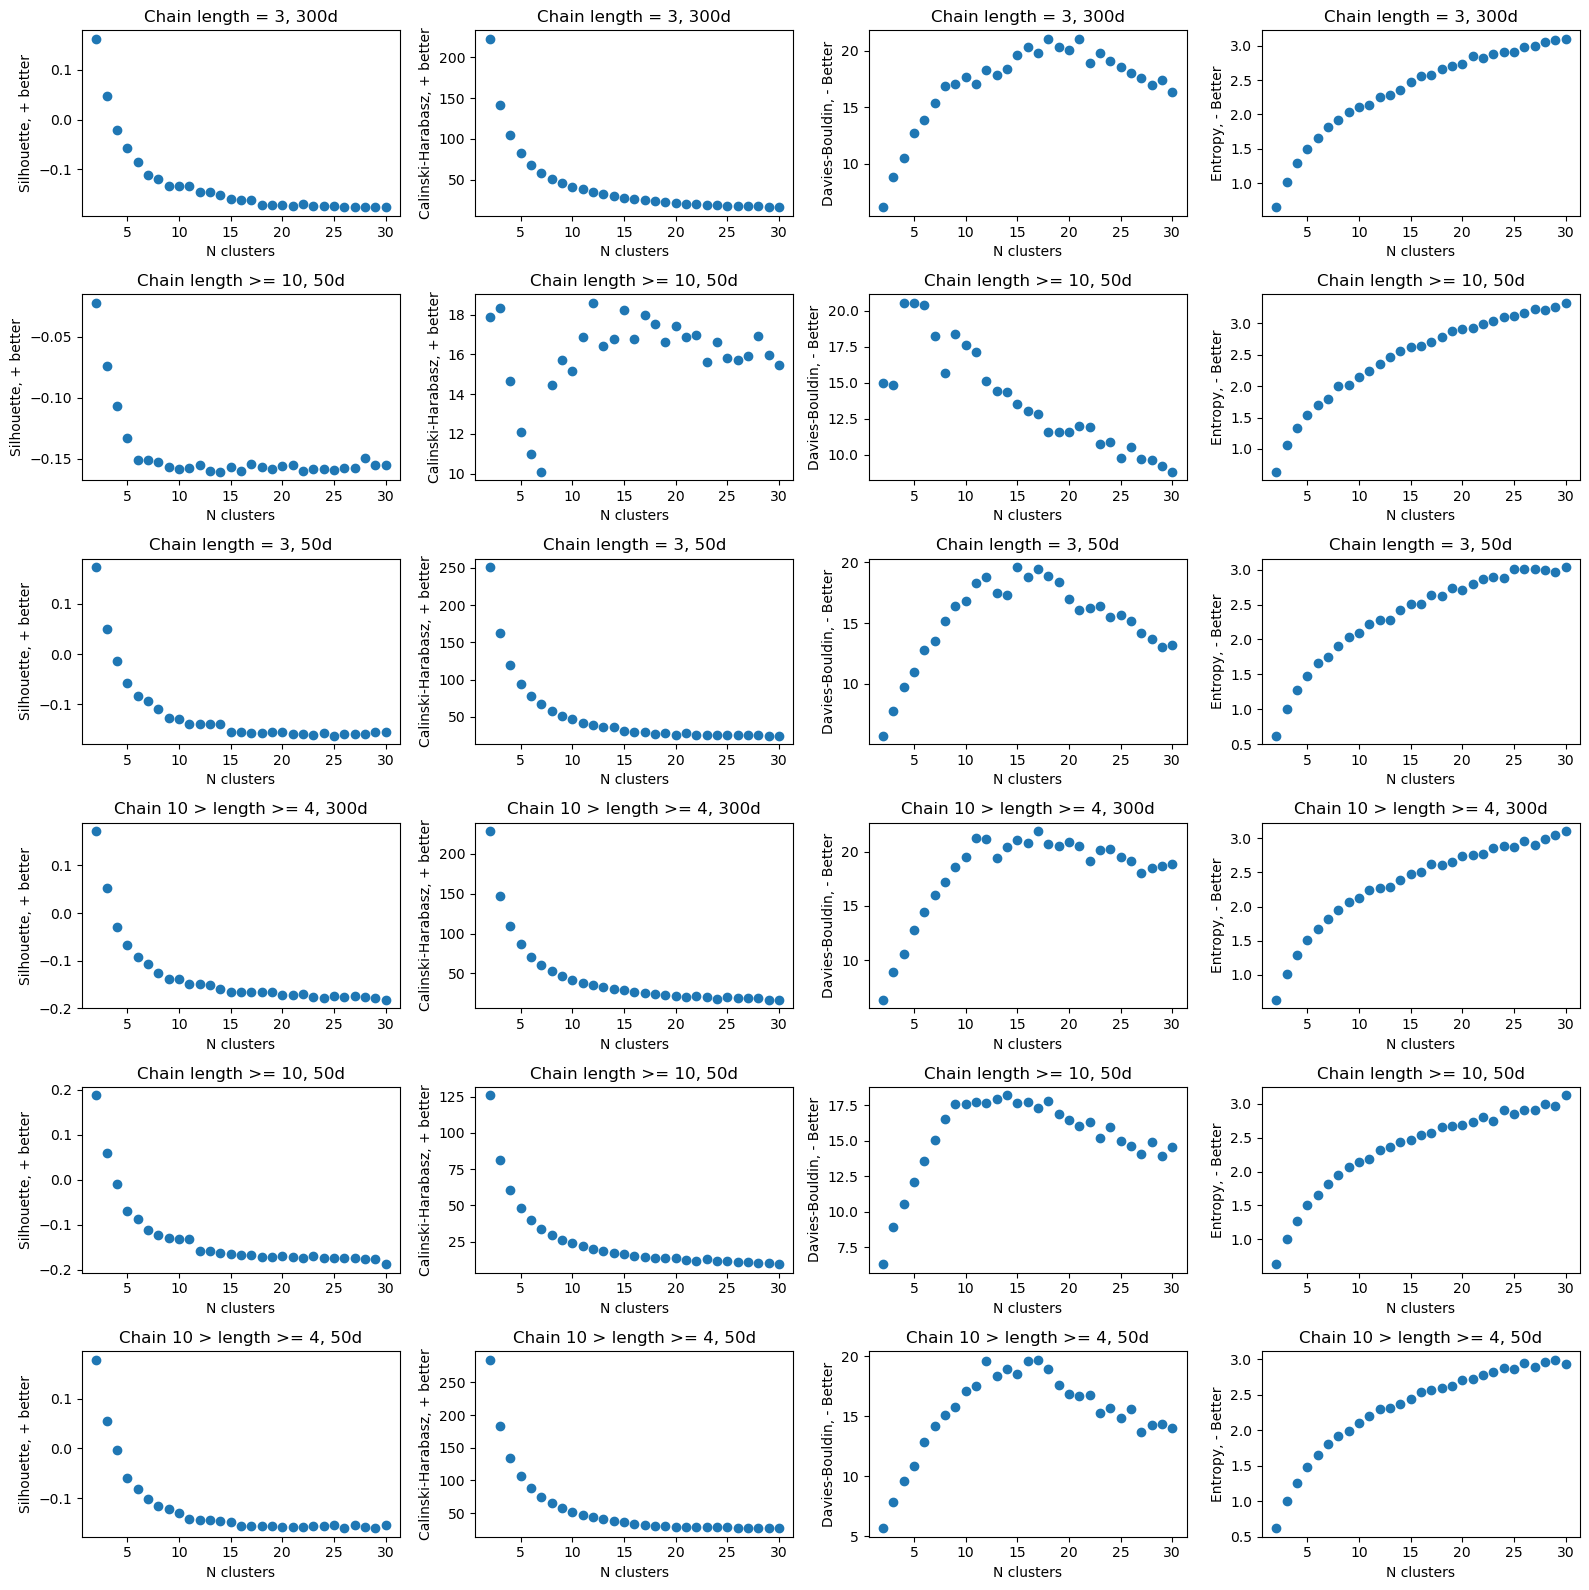

In [42]:
fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))
for row in range(nrows):
    for col in range(ncols):
        X = df_kmeans.loc[(df_kmeans['dataset']==datasets[row]) & (df_kmeans['n_clusters']<=30),['n_clusters', scores[col]]].sort_values('n_clusters')
        axes[row][col].scatter(X['n_clusters'], X[scores[col]])
        axes[row][col].set_title(f'{datasets_dict[datasets[row]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[col])
        # axes[row][col].legend(title='$\lambda$')
        # counter += 1
fig.savefig(Path('../img/scores_km.png'))
plt.show()

In [43]:
km_sl = []
for d in datasets:
    km_sl.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'sl_score',]].sort_values('sl_score',ascending=False).head(1))
df_km_sl = pd.concat(km_sl)
df_km_sl

,dataset,n_clusters,sl_score
0,chains_eq_3_300,2,0.162625
49,chains_ge_10_50,2,-0.022308
98,chains_eq_3_50,2,0.173386
147,chains_ge_4_lt_10_300,2,0.171795
196,chains_ge_10_300,2,0.187294
245,chains_ge_4_lt_10_50,2,0.178924


In [44]:
[f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean' for i, r in df_km_sl.iterrows()]

['labels_km_chains_eq_3_300_02_euclidean',
 'labels_km_chains_ge_10_50_02_euclidean',
 'labels_km_chains_eq_3_50_02_euclidean',
 'labels_km_chains_ge_4_lt_10_300_02_euclidean',
 'labels_km_chains_ge_10_300_02_euclidean',
 'labels_km_chains_ge_4_lt_10_50_02_euclidean']

In [45]:
[r["dataset"] for i, r in df_km_sl.iterrows()]

['chains_eq_3_300',
 'chains_ge_10_50',
 'chains_eq_3_50',
 'chains_ge_4_lt_10_300',
 'chains_ge_10_300',
 'chains_ge_4_lt_10_50']

In [11]:
km_ch = []
for d in datasets:
    km_ch.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'ch_score']].sort_values('ch_score',ascending=False).head(1))
df_km_ch = pd.concat(km_ch)
df_km_ch

,dataset,n_clusters,ch_score
0,chains_eq_3_300,2,222.919579
59,chains_ge_10_50,12,18.590210
98,chains_eq_3_50,2,251.033499
147,chains_ge_4_lt_10_300,2,228.337123
196,chains_ge_10_300,2,125.792456


In [12]:
for i, r in df_km_ch.iterrows():
    print(f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean')

labels_km_chains_eq_3_300_02_euclidean
labels_km_chains_ge_10_50_12_euclidean
labels_km_chains_eq_3_50_02_euclidean
labels_km_chains_ge_4_lt_10_300_02_euclidean
labels_km_chains_ge_10_300_02_euclidean


In [13]:
km_db = []
for d in datasets:
    # km_db.append(df_kmeans.loc[df_kmeans['dataset']==d,['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
    # (df_kmeans['dataset']==datasets[row]) & (df_kmeans['n_clusters']<=30)
    km_db.append(df_kmeans.loc[(df_kmeans['dataset']==d) & (df_kmeans['n_clusters']<=50),['dataset','n_clusters', 'db_score']].sort_values('db_score',ascending=True).head(1))
df_km_db = pd.concat(km_db)
df_km_db

,dataset,n_clusters,db_score
0,chains_eq_3_300,2,6.117431
97,chains_ge_10_50,50,6.733635
98,chains_eq_3_50,2,5.750542
147,chains_ge_4_lt_10_300,2,6.348298
196,chains_ge_10_300,2,6.318584


In [14]:
for i, r in df_km_db.iterrows():
    print(f'labels_km_{r["dataset"]}_{r["n_clusters"]:02d}_euclidean')

labels_km_chains_eq_3_300_02_euclidean
labels_km_chains_ge_10_50_50_euclidean
labels_km_chains_eq_3_50_02_euclidean
labels_km_chains_ge_4_lt_10_300_02_euclidean
labels_km_chains_ge_10_300_02_euclidean


In [15]:
dbscan_list = [pd.read_csv(path) for path in evals_dir.glob('*_dbscan*.csv')]
df_dbscan = pd.concat(dbscan_list, ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']

In [16]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_dbscan['dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
ncols = len(scores)
nrows = len(datasets)
score_colors = [colors.TABLEAU_COLORS['tab:blue'],colors.TABLEAU_COLORS['tab:orange'],colors.TABLEAU_COLORS['tab:green']]
dist_colors = ['#3bbad5', '#3b6dd5', '#3bd5a3']

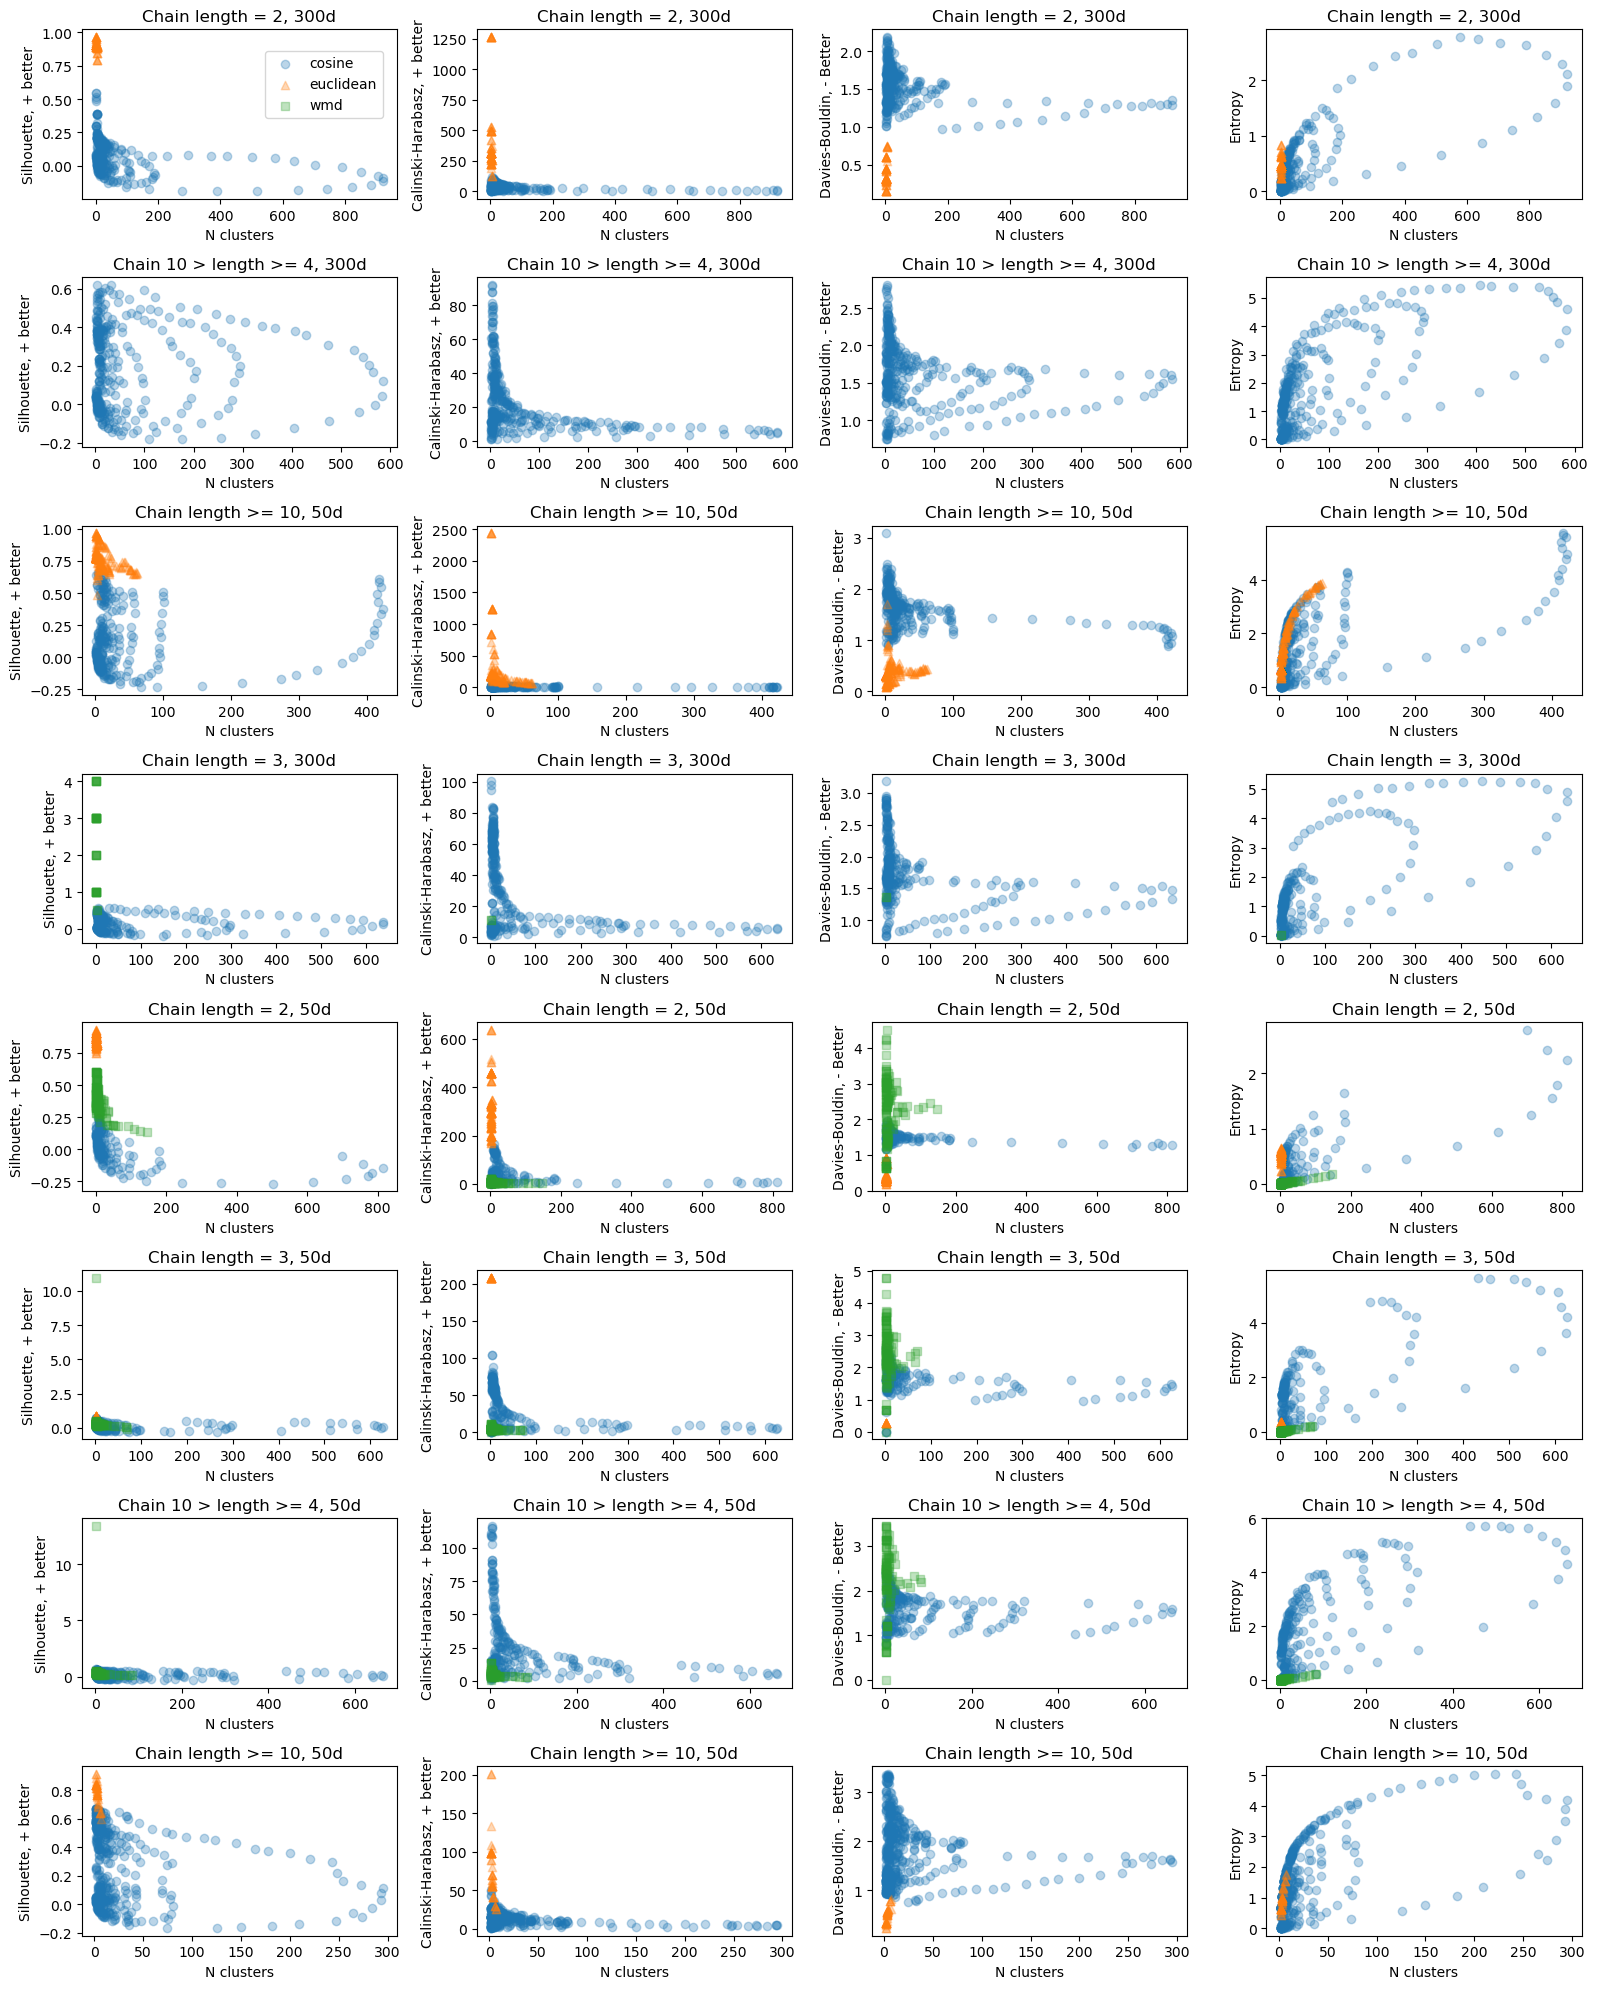

In [37]:
X = df_dbscan.sort_values('n_clusters')
fig, axes = plt.subplots(nrows, ncols, figsize=(16,20))
for row in range(nrows):
    for col in range(ncols):
        x = X[(X['dataset'] == datasets[row]) & (X['distance']=='cosine')]
        axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='cosine', alpha=0.3)
        x = X[(X['dataset'] == datasets[row]) & (X['distance']=='euclidean')]
        axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='euclidean', alpha=0.3, marker='^')
        x = X[(X['dataset'] == datasets[row]) & (X['distance']=='wmd')]
        axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='wmd', alpha=0.3, marker='s')
        # axes[row][col].legend(title='Distance')
        axes[row][col].set_title(f'{datasets_dict[datasets[row]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[col])
        handles, labels = axes[row][col].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.2, 0.975))
# fig.savefig(Path('../img/scores_dbscan.png'))
plt.show()

In [37]:
l_sl = []
for d in datasets:
    l_sl.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'sl_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('sl_score',ascending=False).head(1))
df_sl = pd.concat(l_sl)
df_sl

,dataset,distance,n_clusters,sl_score,epsilon,min_pts,prop_noise
644,chains_eq_2_300,euclidean,2,0.964181,0.66,2,0.998700
1135,chains_ge_4_lt_10_300,cosine,32,0.617345,0.20,3,0.986461
10668,chains_ge_10_50,euclidean,2,0.964790,0.53,2,0.996619
19286,chains_eq_3_300,wmd,1,4.000000,0.20,10,NaN
6356,chains_eq_2_50,euclidean,2,0.931949,0.69,2,0.998574
7336,chains_eq_3_50,wmd,2,10.954556,0.58,2,0.000055
23282,chains_ge_4_lt_10_50,wmd,2,13.392527,0.63,2,0.000054
21336,chains_ge_10_300,euclidean,2,0.916731,0.86,2,0.997558


In [38]:
l_ch = []
for d in datasets:
    l_ch.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'ch_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('ch_score',ascending=False).head(1))
df_ch = pd.concat(l_ch)
df_ch


,dataset,distance,n_clusters,ch_score,epsilon,min_pts,prop_noise
644,chains_eq_2_300,euclidean,2,1262.370956,0.66,2,0.998700
1211,chains_ge_4_lt_10_300,cosine,3,91.897215,0.25,9,0.990699
10668,chains_ge_10_50,euclidean,2,2433.836355,0.53,2,0.996619
15923,chains_eq_3_300,cosine,2,100.261447,0.23,7,0.990649
6356,chains_eq_2_50,euclidean,2,639.064924,0.69,2,0.998574
10052,chains_eq_3_50,euclidean,2,207.982802,0.90,2,0.998061
12527,chains_ge_4_lt_10_50,cosine,3,116.628079,0.23,13,0.972303
21336,chains_ge_10_300,euclidean,2,200.884961,0.86,2,0.997558


In [39]:
l_db = []
for d in datasets:
    l_db.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'db_score', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('db_score',ascending=True).head(1))
df_db = pd.concat(l_db)
df_db

,dataset,distance,n_clusters,db_score,epsilon,min_pts,prop_noise
644,chains_eq_2_300,euclidean,2,0.150688,0.66,2,0.998700
1137,chains_ge_4_lt_10_300,cosine,4,0.745530,0.20,5,0.996900
10668,chains_ge_10_50,euclidean,2,0.076238,0.53,2,0.996619
15923,chains_eq_3_300,cosine,2,0.761152,0.23,7,0.990649
6356,chains_eq_2_50,euclidean,2,0.194879,0.69,2,0.998574
17696,chains_eq_3_50,cosine,2,0.002141,0.69,2,0.000045
23282,chains_ge_4_lt_10_50,wmd,2,0.001960,0.63,2,0.000054
21336,chains_ge_10_300,euclidean,2,0.227793,0.86,2,0.997558


In [40]:
l_en = []
for d in datasets:
    l_en.append(df_dbscan.loc[df_dbscan['dataset']==d,['dataset','distance', 'n_clusters', 'entropy', 'epsilon', 'min_pts', 'prop_noise',]].sort_values('entropy',ascending=True).head(1))
df_en = pd.concat(l_en)
df_en

,dataset,distance,n_clusters,entropy,epsilon,min_pts,prop_noise
8778,chains_eq_2_300,cosine,2,0.000872,0.80,2,0.000587
1554,chains_ge_4_lt_10_300,cosine,2,0.001980,0.50,2,0.011368
25298,chains_ge_10_50,cosine,2,0.003354,0.45,2,0.005259
16268,chains_eq_3_300,cosine,2,0.002180,0.48,2,0.019957
14224,chains_eq_2_50,wmd,2,0.000872,0.64,2,0.000336
17246,chains_eq_3_50,cosine,2,0.001387,0.36,14,0.188505
23268,chains_ge_4_lt_10_50,wmd,2,0.001961,0.62,2,0.000207
26572,chains_ge_10_300,cosine,2,0.003381,0.55,2,0.014087


In [43]:
hdbscan_list = [pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')]
df_hdbscan = pd.concat(hdbscan_list, ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']

In [46]:
dfdf_hdbscan[~df_hdbscan['dataset'].isin(['chains_eq_2_50','chains_eq_2_300'])]

,distance,dataset,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,size,prop_noise
0,wmd,chains_ge_4_lt_10_300,5,5,12,9516,0.075647,4.483004,3.396320,1.932685,9676,0.983464
1,wmd,chains_ge_4_lt_10_300,5,6,2,3643,0.267244,3.277349,2.875495,0.006709,9676,0.376499
2,wmd,chains_ge_4_lt_10_300,5,7,4,9562,0.197013,13.919690,2.138550,0.912417,9676,0.988218
3,wmd,chains_ge_4_lt_10_300,5,8,3,9531,0.134619,19.869648,1.594915,0.642550,9676,0.985014
4,wmd,chains_ge_4_lt_10_300,5,9,2,9537,0.150321,23.533078,1.136395,0.512140,9676,0.985635
...,...,...,...,...,...,...,...,...,...,...,...,...
4603,cosine,chains_eq_3_50,20,16,2,7977,0.178919,55.949070,1.170244,0.117831,8769,0.909682
4604,cosine,chains_eq_3_50,20,17,4,8509,0.433149,63.981797,1.473298,1.180910,8769,0.970350
4605,cosine,chains_eq_3_50,20,18,4,8494,0.422267,63.369951,1.502121,1.162647,8769,0.968640
4606,cosine,chains_eq_3_50,20,19,4,8498,0.427547,65.208771,1.483781,1.166172,8769,0.969096


In [48]:
scores = ['sl_score','ch_score','db_score', 'entropy']
datasets = df_hdbscan.loc[~df_hdbscan['dataset'].isin(['chains_eq_2_50','chains_eq_2_300']),'dataset'].unique()
score_names = ['Silhouette, + better', 'Calinski-Harabasz, + better', 'Davies-Bouldin, - Better', 'Entropy']
ncols = len(scores)
nrows = len(datasets)
datasets_dict = {
    'chains_eq_2_300': 'Chain length = 2, 300d',
    'chains_eq_3_300': 'Chain length = 3, 300d',
    'chains_ge_4_lt_10_50': 'Chain 10 > length >= 4, 50d',
    'chains_eq_3_50': 'Chain length = 3, 50d',
    'chains_ge_10_300': 'Chain length >= 10, 50d',
    'chains_ge_4_lt_10_300': 'Chain 10 > length >= 4, 300d',
    'chains_eq_2_50': 'Chain length = 2, 50d',
    'chains_ge_10_50': 'Chain length >= 10, 50d'}
score_colors = [colors.TABLEAU_COLORS['tab:blue'],colors.TABLEAU_COLORS['tab:orange'],colors.TABLEAU_COLORS['tab:green']]
dist_colors = ['#3bbad5', '#3b6dd5', '#3bd5a3']

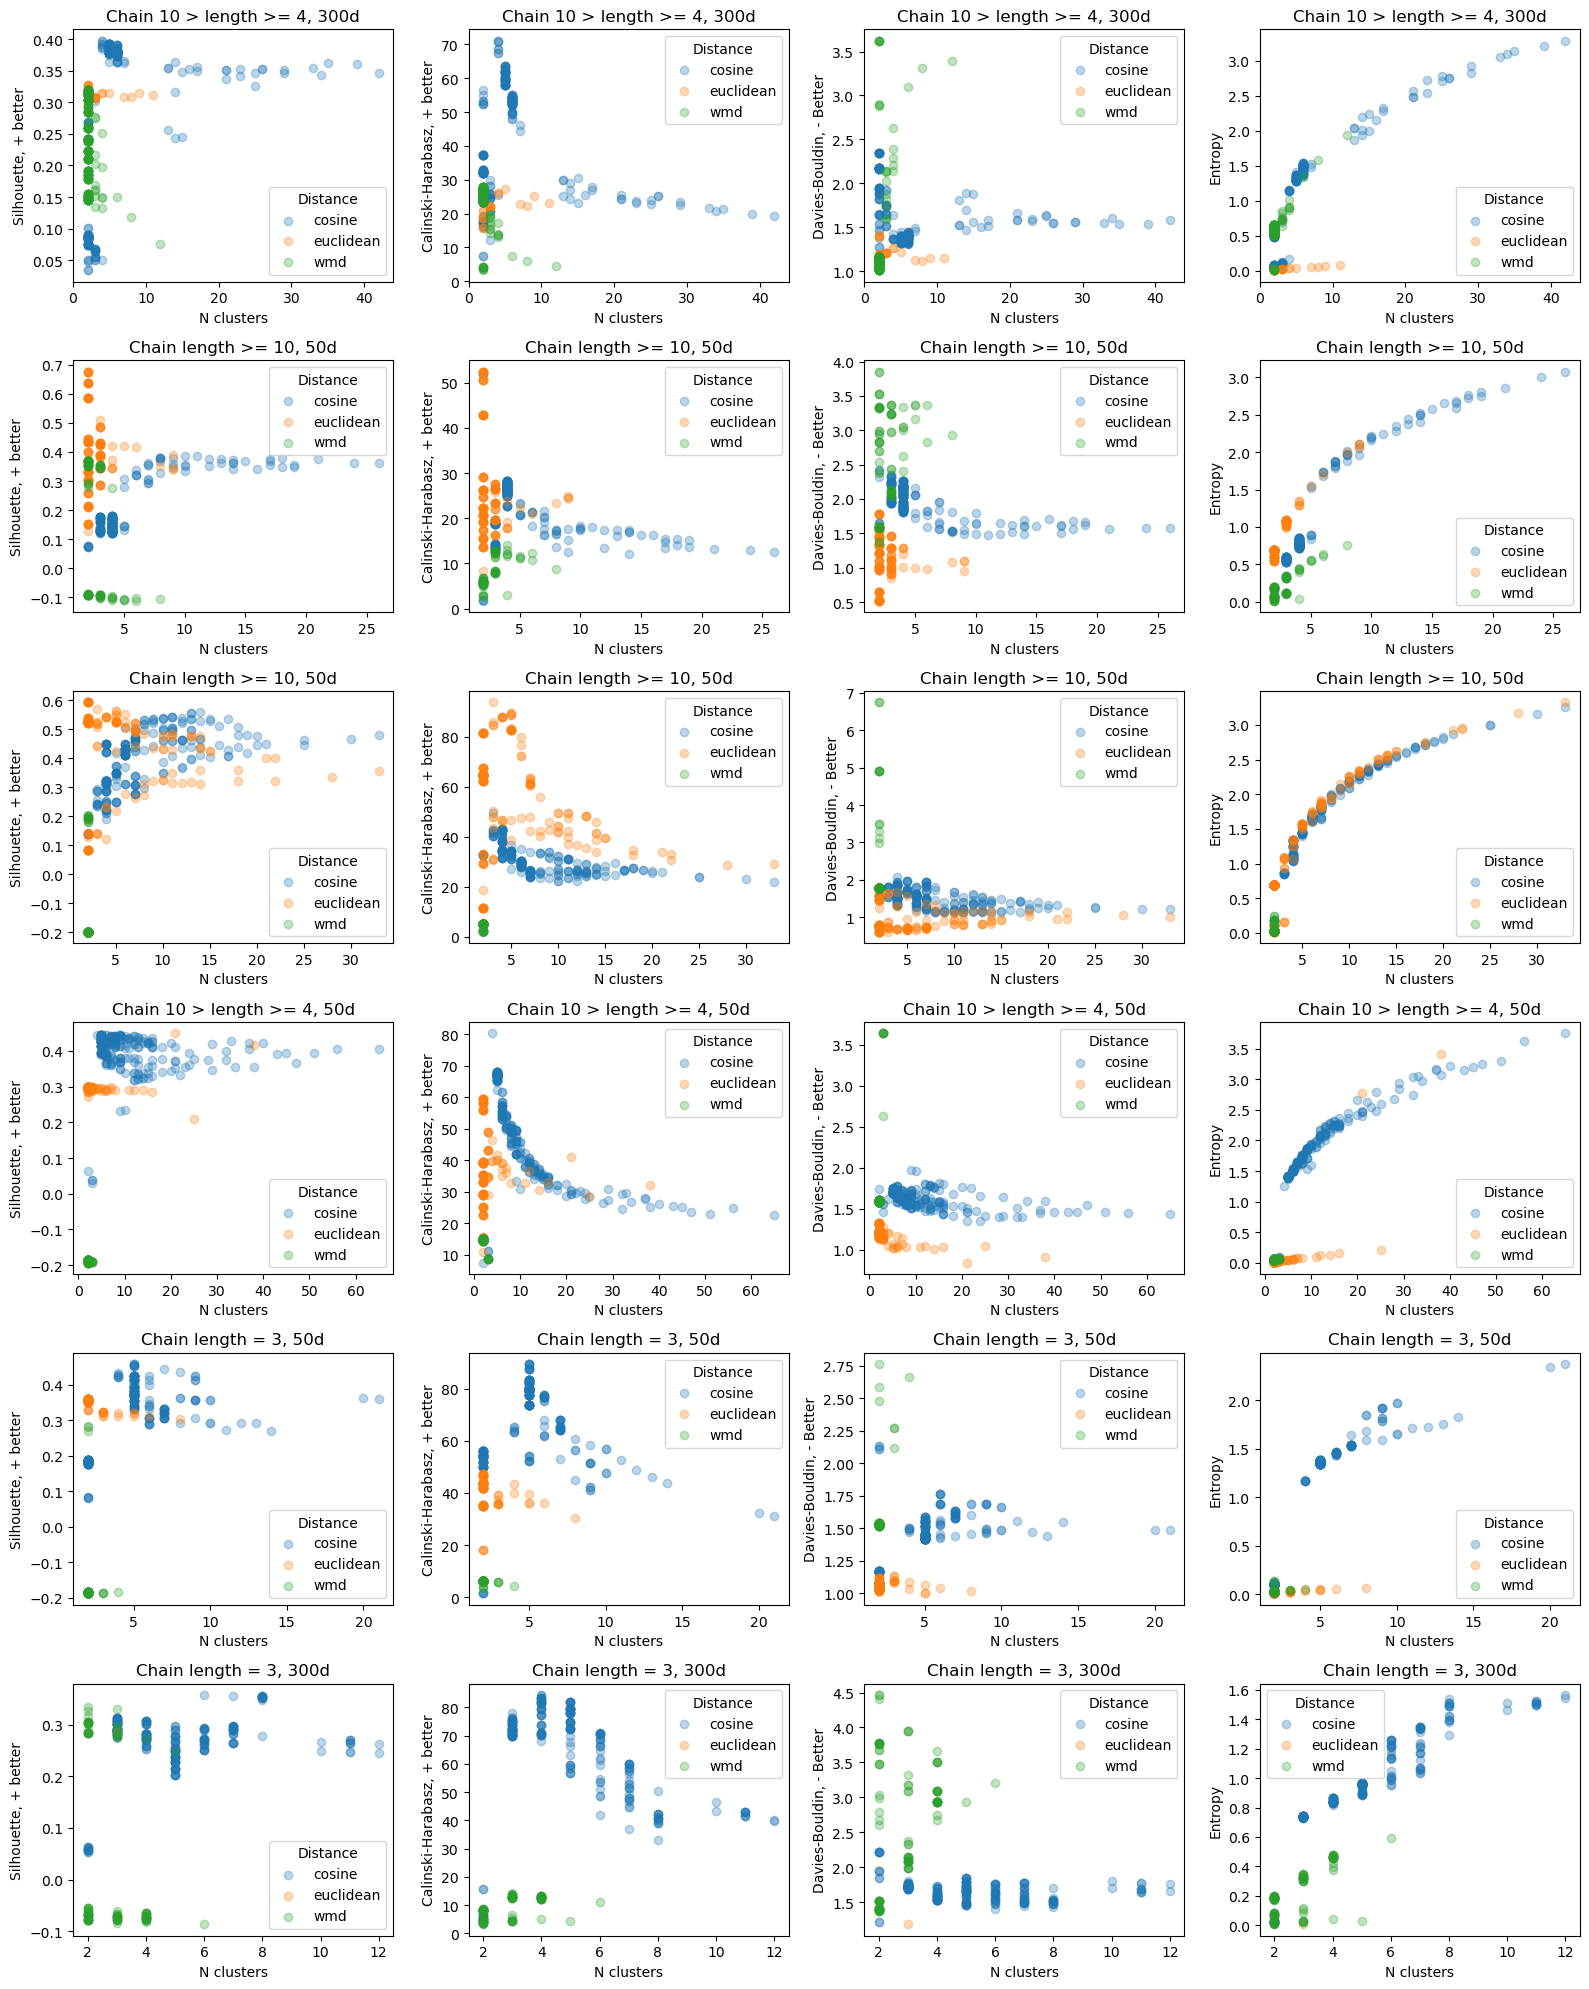

In [49]:
X = df_hdbscan.sort_values('n_clusters')
fig, axes = plt.subplots(nrows, ncols, figsize=(16,20))
for row in range(nrows):
    for col in range(ncols):
        x = X[(X['dataset'] == datasets[row]) & (X['distance']=='cosine')]
        axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='cosine', alpha=0.3)
        x = X[(X['dataset'] == datasets[row]) & (X['distance']=='euclidean')]
        axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='euclidean', alpha=0.3)
        x = X[(X['dataset'] == datasets[row]) & (X['distance']=='wmd')]
        axes[row][col].scatter(x['n_clusters'], x[scores[col]], label='wmd', alpha=0.3)
        axes[row][col].legend(title='Distance')
        axes[row][col].set_title(f'{datasets_dict[datasets[row]]}')
        axes[row][col].set_xlabel('N clusters')
        axes[row][col].set_ylabel(score_names[col])
fig.savefig(Path('../img/scores_hdbscan.png'))
plt.show()

In [42]:
l_sl = []
for d in datasets:
    l_sl.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'sl_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('sl_score',ascending=False).head(1))
df_sl = pd.concat(l_sl)
df_sl

NameError: name 'df_hdbscan' is not defined

In [33]:
l_ch = []
for d in datasets:
    l_ch.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'ch_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('ch_score',ascending=False).head(1))
df_ch = pd.concat(l_ch)
df_ch

,dataset,distance,n_clusters,ch_score,min_clt_size,min_samples,prop_noise
4576,chains_eq_2_300,euclidean,2,194.439625,8,20,0.998196
1271,chains_eq_3_300,cosine,3,99.099878,20,12,0.931007
4297,chains_ge_4_lt_10_50,euclidean,3,158.575317,20,2,0.810149
722,chains_eq_3_50,cosine,5,89.413745,18,7,0.937393
3594,chains_ge_10_300,euclidean,2,60.770650,12,17,0.992863
4131,chains_ge_4_lt_10_300,euclidean,2,362.575438,2,12,0.995763
4687,chains_eq_2_50,euclidean,2,186.811229,7,20,0.998364
4835,chains_ge_10_50,euclidean,3,93.603424,14,9,0.989106


In [29]:
l_db = []
for d in datasets:
    l_db.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'db_score', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('db_score',ascending=True).head(1))
df_db = pd.concat(l_db)
df_db

,dataset,distance,n_clusters,db_score,min_clt_size,min_samples,prop_noise
4138,chains_eq_2_300,euclidean,2,0.406400,9,20,0.998196
3916,chains_eq_3_300,euclidean,2,0.790497,14,3,0.996351
3446,chains_ge_4_lt_10_50,euclidean,4,0.660538,2,13,0.994212
4278,chains_eq_3_50,euclidean,146,0.912354,3,3,0.935568
3561,chains_ge_10_300,euclidean,2,0.657548,4,19,0.993238
4131,chains_ge_4_lt_10_300,euclidean,2,0.326665,2,12,0.995763
4687,chains_eq_2_50,euclidean,2,0.434176,7,20,0.998364
4835,chains_ge_10_50,euclidean,3,0.613239,14,9,0.989106


In [30]:
l_en = []
for d in datasets:
    l_en.append(df_hdbscan.loc[df_hdbscan['dataset']==d,['dataset','distance', 'n_clusters', 'entropy', 'min_clt_size', 'min_samples', 'prop_noise',]].sort_values('entropy',ascending=True).head(1))
df_en = pd.concat(l_en)
df_en

,dataset,distance,n_clusters,entropy,min_clt_size,min_samples,prop_noise
4718,chains_eq_2_300,euclidean,2,0.003424,9,4,0.023321
2755,chains_eq_3_300,euclidean,2,0.003499,3,9,0.136161
4915,chains_ge_4_lt_10_50,euclidean,2,0.002779,2,20,0.323687
3732,chains_eq_3_50,euclidean,2,0.003588,2,17,0.160338
3180,chains_ge_10_300,euclidean,2,0.005482,3,5,0.144252
4127,chains_ge_4_lt_10_300,euclidean,2,0.006794,7,8,0.016639
2972,chains_eq_2_50,euclidean,2,0.000872,2,4,0.000419
2434,chains_ge_10_50,euclidean,2,0.016569,10,10,0.120586


In [4]:
hbscan_list = [pd.read_csv(path) for path in data_dir.glob('*hdbscan*.csv')]
df_hdbscan = pd.concat(hbscan_list, ignore_index=True)

In [6]:
df_hdbscan

,distance,dataset,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,Unnamed: 0
0,cosine,chains_ge_4_lt_10_300,5,5,62,8838.0,0.342927,15.619720,1.486134,3.560448,NaN
1,cosine,chains_ge_4_lt_10_300,5,6,41,8833.0,0.281907,21.716202,1.498343,2.778065,NaN
2,cosine,chains_ge_4_lt_10_300,5,7,30,8932.0,0.288140,23.992153,1.532128,2.478530,NaN
3,cosine,chains_ge_4_lt_10_300,5,8,20,9018.0,0.301208,30.742874,1.503282,2.142413,NaN
4,cosine,chains_ge_4_lt_10_300,5,9,20,9152.0,0.335928,24.405591,1.507168,2.315367,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5955,wmd,chains_eq_3_50,20,16,0,8769.0,NaN,NaN,NaN,NaN,NaN
5956,wmd,chains_eq_3_50,20,17,0,8769.0,NaN,NaN,NaN,NaN,NaN
5957,wmd,chains_eq_3_50,20,18,0,8769.0,NaN,NaN,NaN,NaN,NaN
5958,wmd,chains_eq_3_50,20,19,0,8769.0,NaN,NaN,NaN,NaN,NaN


In [41]:
tab_hdbscan = df_hdbscan.groupby(by=['dataset', 'distance'])[['entropy', 'sl_score', 'ch_score', 'db_score', 'n_clusters']].max().sort_values(by=['dataset', 'entropy'], ascending=[True, False])

In [44]:
print(tab_hdbscan.to_latex(float_format="%.3f", longtable=True, decimal=',', label='tab:hdbscanscores', caption='HDBSCAN Best Scores'))

\begin{longtable}{llrrrrr}
\caption{HDBSCAN Best Scores}
\label{tab:hdbscanscores}\\
\toprule
                     &     &  entropy &  sl\_score &  ch\_score &  db\_score &  n\_clusters \\
dataset & distance &          &           &           &           &             \\
\midrule
\endfirsthead
\caption[]{HDBSCAN Best Scores} \\
\toprule
                     &     &  entropy &  sl\_score &  ch\_score &  db\_score &  n\_clusters \\
dataset & distance &          &           &           &           &             \\
\midrule
\endhead
\midrule
\multicolumn{7}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
chains\_eq\_2\_300 & euclidean &    6,479 &     0,840 &   194,440 &     1,518 &         758 \\
chains\_eq\_2\_50 & euclidean &    6,603 &     0,845 &   186,811 &     1,427 &         896 \\
chains\_eq\_3\_300 & euclidean &    5,899 &     0,565 &    51,176 &     2,335 &         407 \\
                     & cosine &    1,993 &     0,340 &    99,100 &     2,078 &  

/tmp/ipykernel_21942/2463155231.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab_hdbscan.to_latex(float_format="%.3f", longtable=True, decimal=',', label='tab:hdbscanscores', caption='HDBSCAN Best Scores'))


In [16]:
hdbscan_res[-1]

PosixPath('/home/miguel/Projects/tfm-nlp/data/interim/eval_hdbscan_1664206430.csv')

In [58]:
dbscan_list = [pd.read_csv(path) for path in data_dir.glob('*_dbscan*.csv')]
df_dbscan = pd.concat(dbscan_list, ignore_index=True)

In [61]:
tab_dbscan = df_dbscan.groupby(by=['dataset', 'distance'])[['entropy', 'sl_score', 'ch_score', 'db_score', 'n_clusters']].max().sort_values(by=['dataset', 'entropy'], ascending=[True, False])

In [62]:
tab_dbscan

entropy   sl_score     ch_score  db_score  \
dataset               distance                                                
chains_eq_2_300       cosine     2.536004   0.519763   226.969215  2.374681   
                      euclidean  0.829369   0.951246   705.024506  1.214817   
                      wmd             NaN        NaN          NaN       NaN   
chains_eq_2_50        cosine     2.796862   0.368917   163.515089  1.945292   
                      euclidean  0.653418   0.931949   639.064924  0.902965   
                      wmd        0.168714   0.599960    18.410150  4.514679   
chains_eq_3_300       cosine     5.085854   0.583026    83.970675  3.248785   
                      euclidean       NaN        NaN          NaN       NaN   
                      wmd             NaN   2.000000          NaN       NaN   
chains_eq_3_50        cosine     5.650931   0.694451   103.649793  2.656876   
                      euclidean  0.362211   0.897367   207.982802  0.266966   
                      wmd        0.226067  10.954556    11.580764  4.779841   
chains_ge_10_300      cosine     4.549284   0.709365    53.445958  3.459773   
                      euclidean  1.709417   0.940787   416.221191  1.612928   
                      wmd             NaN        NaN          NaN       NaN   
chains_ge_10_50       cosine     5.711917   0.655569    57.443697  3.084444   
                      euclidean  3.867868   0.964790  2433.836355  1.700264   
                      wmd             NaN        NaN          NaN       NaN   
chains_ge_4_lt_10_300 cosine     5.396378   0.636109    92.568616  2.966682   
                      euclidean  0.257319   0.942392   362.575438  0.382401   
                      wmd             NaN   2.000000          NaN       NaN   
chains_ge_4_lt_10_50  cosine     5.722414   0.646877   116.628079  2.400075   
                      wmd        0.222263  13.392527    13.417726  3.446396   
                      euclidean       NaN        NaN          NaN       NaN   

                                 n_clusters  
dataset               distance               
chains_eq_2_300       cosine            848  
                      euclidean           4  
                      wmd                 1  
chains_eq_2_50        cosine            814  
                      euclidean           4  
                      wmd               147  
chains_eq_3_300       cosine            618  
                      euclidean           1  
                      wmd                 1  
chains_eq_3_50        cosine            627  
                      euclidean           2  
                      wmd                70  
chains_ge_10_300      cosine            278  
                      euclidean           8  
                      wmd                 1  
chains_ge_10_50       cosine            423  
                      euclidean          62  
                      wmd                 1  
chains_ge_4_lt_10_300 cosine            604  
                      euclidean           2  
                      wmd                 1  
chains_ge_4_lt_10_50  cosine            664  
                      wmd                84  
                      euclidean           1

In [63]:
df_dbscan.groupby(by=['dataset', 'distance'])[['sl_score', 'n_clusters','n_noise']].max().sort_values(by=['dataset','sl_score'], ascending=[True, False])

sl_score  n_clusters  n_noise
dataset               distance                                 
chains_eq_2_300       euclidean   0.951246           4  23809.0
                      cosine      0.519763         848  22450.0
                      wmd              NaN           1      3.0
chains_eq_2_50        euclidean   0.931949           4  23809.0
                      wmd         0.599960         147   4691.0
                      cosine      0.368917         814  19795.0
chains_eq_3_300       wmd         2.000000           1      NaN
                      cosine      0.583026         618   8733.0
                      euclidean        NaN           1   8754.0
chains_eq_3_50        wmd        10.954556          70   2464.0
                      euclidean   0.897367           2   8754.0
                      cosine      0.694451         627   8634.0
chains_ge_10_300      euclidean   0.940787           8   5308.0
                      cosine      0.709365         278   5303.0
                      wmd              NaN           1      NaN
chains_ge_10_50       euclidean   0.964790          62   5308.0
                      cosine      0.655569         423   5290.0
                      wmd              NaN           1      NaN
chains_ge_4_lt_10_300 wmd         2.000000           1      NaN
                      euclidean   0.942392           2   9637.0
                      cosine      0.636109         604   9676.0
chains_ge_4_lt_10_50  wmd        13.392527          84   2414.0
                      cosine      0.646877         664   9566.0
                      euclidean        NaN           1   9637.0

In [77]:
df_dbscan[df_dbscan['distance']=='wmd'].dropna(subset=['db_score'])['min_pts'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [105]:
datasets = df_kmeans['dataset'].unique()

In [107]:
datasets

array(['chains_ge_4_lt_10_50', 'chains_eq_3_50', 'chains_eq_3_300',
       'chains_ge_10_50', 'chains_ge_4_lt_10_300', 'chains_eq_2_300',
       'chains_ge_10_300'], dtype=object)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))

cmap = mpl.cm.viridis
bounds = sorted(df_1e4['min_clt_size'].unique())
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

pc = axes[0].scatter(df_1e4['min_samples'], df_1e4['sl_score'], c=df_1e4['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[0], extend='both', label='Min. Cluster Size')
axes[0].set_xlabel('Minimum samples')
axes[0].set_ylabel('Silhouette Score')
pc = axes[1].scatter(df_1e4['min_samples'], df_1e4['ch_score'], c=df_1e4['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[1], extend='both', label='Min. Cluster Size')
axes[1].set_xlabel('Minimum samples')
axes[1].set_ylabel('Calinski Harabasz Score')
pc = axes[2].scatter(df_1e4['min_samples'], df_1e4['db_score'], c=df_1e4['min_clt_size'], norm=norm, cmap=cmap)
fig.colorbar(pc, ax=axes[2], extend='both', label='Min. Cluster Size')
axes[2].set_xlabel('Minimum samples')
axes[2].set_ylabel('Davies Bouldin Score')


plt.show()

In [85]:
df_kmeans['method'] = 'Kmeans'

In [86]:
df_hdbscan['method'] = 'HDBSCAN'

In [87]:
df_dbscan['method'] = 'DBSCAN'

In [97]:
df_kmeans

,distance,dataset,epsilon,min_pts,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,Unnamed: 9,method
0,wmd,chains_eq_2_300,0.2,2,1,1.0,NaN,NaN,NaN,NaN,NaN,Kmeans
1,wmd,chains_eq_2_300,0.2,3,1,1.0,NaN,NaN,NaN,NaN,NaN,Kmeans
2,wmd,chains_eq_2_300,0.2,4,1,1.0,NaN,NaN,NaN,NaN,NaN,Kmeans
3,wmd,chains_eq_2_300,0.2,5,1,1.0,NaN,NaN,NaN,NaN,NaN,Kmeans
4,wmd,chains_eq_2_300,0.2,6,1,1.0,NaN,NaN,NaN,NaN,NaN,Kmeans
...,...,...,...,...,...,...,...,...,...,...,...,...
27211,wmd,chains_ge_4_lt_10_300,1.0,11,1,NaN,NaN,NaN,NaN,NaN,NaN,Kmeans
27212,wmd,chains_ge_4_lt_10_300,1.0,12,1,NaN,NaN,NaN,NaN,NaN,NaN,Kmeans
27213,wmd,chains_ge_4_lt_10_300,1.0,13,1,NaN,NaN,NaN,NaN,NaN,NaN,Kmeans
27214,wmd,chains_ge_4_lt_10_300,1.0,14,1,NaN,NaN,NaN,NaN,NaN,NaN,Kmeans


In [96]:
df_hdbscan.dropna(subset='Unnamed: 0')

,distance,dataset,min_clt_size,min_samples,n_clusters,n_noise,sl_score,ch_score,db_score,entropy,Unnamed: 0,method
2048,euclidean,chains_ge_4_lt_10_50,7,5,16,2635.0,0.285629,32.948824,1.040004,0.156613,0.0,HDBSCAN
2049,euclidean,chains_eq_2_300,5,19,2,23797.0,0.827860,184.153913,0.418089,0.585953,1.0,HDBSCAN
2050,euclidean,chains_ge_4_lt_10_50,20,18,0,9676.0,NaN,NaN,NaN,NaN,2.0,HDBSCAN
2051,euclidean,chains_ge_4_lt_10_300,20,2,2,9616.0,0.682134,69.075103,0.740999,0.647447,3.0,HDBSCAN
2052,euclidean,chains_ge_4_lt_10_50,2,17,2,3070.0,0.285477,15.490210,1.147296,0.008317,4.0,HDBSCAN
...,...,...,...,...,...,...,...,...,...,...,...,...
4931,euclidean,chains_eq_3_300,14,4,2,552.0,0.321243,28.690796,1.359210,0.012564,2883.0,HDBSCAN
4932,euclidean,chains_ge_4_lt_10_300,4,18,0,9676.0,NaN,NaN,NaN,NaN,2884.0,HDBSCAN
4933,euclidean,chains_ge_4_lt_10_50,3,15,2,3022.0,0.298189,25.064494,1.160815,0.012240,2885.0,HDBSCAN
4934,euclidean,chains_eq_2_50,9,13,2,6303.0,0.390667,35.822914,1.013355,0.005252,2886.0,HDBSCAN
